In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/sample_data/lfw.zip',outdir='/content/sample_data')
path = '/content/sample_data/lfw'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.2 MB/s eta 0:00:00


INFO patool: Extracting /content/sample_data/lfw.zip ...
INFO:patool:Extracting /content/sample_data/lfw.zip ...
INFO patool: running /usr/bin/7z x -o/content/sample_data -- /content/sample_data/lfw.zip
INFO:patool:running /usr/bin/7z x -o/content/sample_data -- /content/sample_data/lfw.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/sample_data/lfw.zip extracted to `/content/sample_data'.
INFO:patool:... /content/sample_data/lfw.zip extracted to `/content/sample_data'.


In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([32, 3, 250, 250])
torch.Size([250, 250, 3])


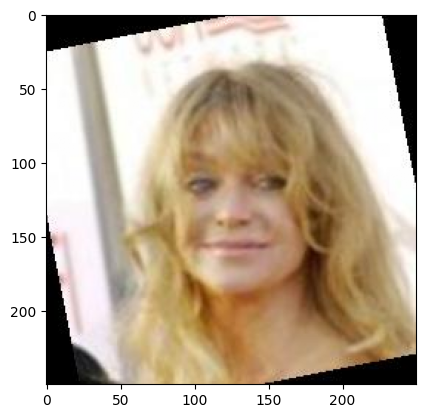

In [5]:
for x,y in dataloader:
    print(x.shape)
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE,self).__init__()
        flat_input_size=3 * 250 * 250
        hidden_size=512

        # latent_size=50
        latent_size=32

        self.fc_1 = nn.Linear(flat_input_size, hidden_size)
        self.fc_2_1 = nn.Linear(hidden_size, latent_size)
        self.fc_2_2 = nn.Linear(hidden_size, latent_size)

        # Decoder layers
        self.fc_3 = nn.Linear(latent_size, hidden_size)
        self.fc_4 = nn.Linear(hidden_size, flat_input_size)



    def encoder(self,x):
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc_1(x))
        mean = self.fc_2_1(x)
        log_var = self.fc_2_2(x)
        return x,mean, log_var

    def decoder(self,x):
        x = nn.functional.relu(self.fc_3(x))
        x = torch.sigmoid(self.fc_4(x))
        x = x.view(x.size(0), 3, 250, 250)
        return x


    def forward(self,x):

        x,mean, log_var = self.encoder(x)

        z = self.reparameterize(mean, log_var)


        x_recon = self.decoder(z)

        return x_recon, mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

tensor([[ 1.3538e-01, -1.4632e-01, -7.0480e-02,  ..., -1.5437e-01,
          1.5337e-04, -1.2708e-01],
        [-1.8179e-02,  1.0049e-02,  3.2685e-02,  ..., -2.1262e-02,
         -3.9456e-02, -1.9209e-01],
        [ 7.7466e-02, -1.9110e-01, -8.3647e-02,  ...,  4.3192e-02,
          5.5973e-02, -2.0786e-01],
        ...,
        [ 1.4956e-01, -1.2238e-01, -1.1093e-01,  ...,  1.8141e-03,
          4.1726e-02, -1.5364e-01],
        [ 5.4233e-02,  7.5997e-02, -2.0514e-02,  ...,  5.1213e-03,
          4.5738e-02, -1.4677e-01],
        [ 1.2938e-01, -6.7365e-02,  8.5665e-02,  ..., -1.2851e-01,
          2.5257e-02, -7.1415e-02]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0576, -0.1346, -0.0790,  ...,  0.2935,  0.2629,  0.0653],
        [ 0.0828, -0.0534, -0.0696,  ...,  0.1395,  0.0610, -0.0008],
        [ 0.0299, -0.1291, -0.1109,  ...,  0.3579,  0.3234, -0.0363],
        ...,
        [ 0.0403, -0.0817, -0.1120,  ...,  0.2613,  0.2300,  0.0195],
        [ 0.0165, -0.0670, -0.0216,  ...,  0.1618

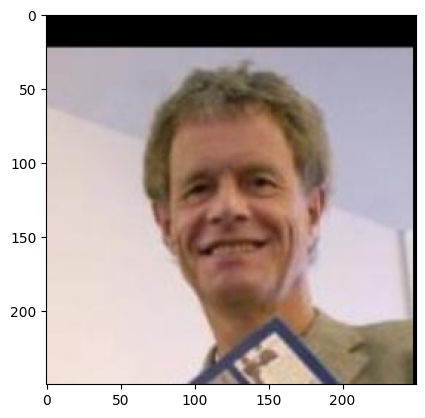

In [9]:
model = VAE()
for x,y in dataloader:
    z = x[0].permute(1, 2, 0)
    # print(z.shape)
    # print(y)
    plt.imshow(z)
    output,output_mean, output_logvar = model.encoder(x)

    # plt.imshow(encoder_output)
    print(output_logvar)
    print(output_mean)
    print(output.data.shape)
    decoder_output=model.decoder(output.permute(1,0))
    print(decoder_output.data.shape)
    # plt.imshow(output)
    break

Generating new samples in the latent space using a trained Variational Autoencoder (VAE) involves sampling from the learned latent space distribution and then decoding these samples using the decoder part of the VAE.
To generate new samples, we can sample random values from latent space and then transform them using the learned mean and log_var from the encoder. This is done in the reparameterization.
Once you have the samples from the latent space, pass them through the decoder to generate new data points

Output of Decoder: torch.Size([32, 3, 250, 250])


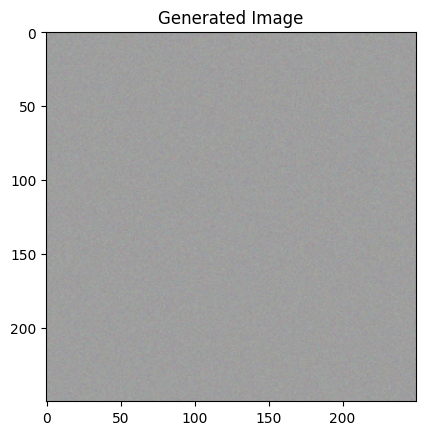

In [10]:
# generated_images = model.decoder(torch.randn_like(output_mean))

generated_images = torch.sigmoid(model.decoder(torch.randn_like(output_mean)))

print("Output of Decoder:", generated_images.shape)
generated_image_sample = generated_images[0].detach().numpy().transpose(1, 2, 0)

plt.imshow(generated_image_sample)
plt.title('Generated Image')
plt.show()

In [11]:
# encoder_output=output[0].detach().cpu().numpy()
# # plt.imshow(encoder_output.transpose(1,2,0))
# # plt.imshow(encoder_output[0].reshape((1, 2)))
# # plt.imshow(encoder_output.transpose(1,2,0), cmap='viridis')
# plt.imshow(encoder_output.transpose(1,2,0)[:,:,0], cmap='gray')
# plt.title('Encoded Image')
# plt.show()

latent_space_representation = output


print(latent_space_representation[0])


# plt.hist(latent_space_representation[0].detach().numpy(), bins=20)
# plt.title('Histogram of Latent Space Values')
# plt.show()

tensor([0.0000e+00, 0.0000e+00, 1.3112e-01, 6.8772e-04, 5.0333e-01, 0.0000e+00,
        5.2018e-02, 4.3501e-01, 3.2963e-01, 3.0856e-01, 0.0000e+00, 5.2079e-01,
        0.0000e+00, 2.1256e-01, 0.0000e+00, 8.8957e-01, 0.0000e+00, 5.9972e-01,
        0.0000e+00, 4.0302e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.5429e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.9726e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9204e-02, 0.0000e+00,
        0.0000e+00, 6.5284e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.4483e-02, 0.0000e+00, 0.0000e+00, 2.7910e-01, 0.0000e+00, 0.0000e+00,
        1.5568e-02, 0.0000e+00, 6.0624e-01, 0.0000e+00, 8.9885e-01, 9.9173e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6989e-01, 0.0000e+00,
        0.0000e+00, 9.3914e-01, 4.5863e-01, 3.9075e-01, 0.0000e+00, 0.0000e+00,
        3.1526e-01, 4.8539e-02, 0.0000e+00, 0.0000e+00, 4.1689e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

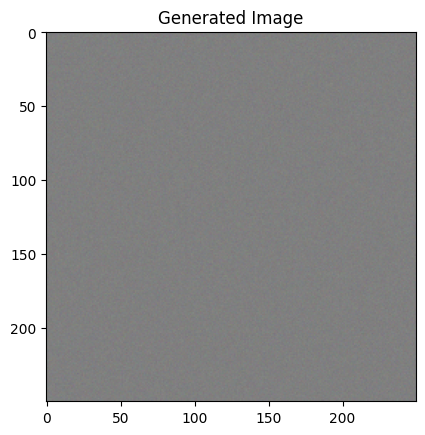

In [12]:
generated_image_sample = decoder_output[0].detach().numpy().transpose(1, 2, 0)

plt.imshow(generated_image_sample)
plt.title('Generated Image')
plt.show()

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


decoder_output: This is the reconstructed output from the VAE decoder. It represents the model's attempt to recreate the input data x from its latent representation.

x: This is the original input data.

output_mean: This is the mean of the distribution in the latent space. It is one of the outputs from the encoder, representing the center of the learned distribution.

log_var: This is the logarithm of the variance of the distribution in the latent space. It is also an output from the encoder and is used to parameterize the distribution.

nn.functional.binary_cross_entropy: This function calculates the binary cross-entropy loss between the reconstructed output (recon_x) and the original input (x). This loss is appropriate for binary data, such as pixel values in binary images.

kl_divergence: This calculates the KL divergence between the learned distribution in the latent space and a predefined prior distribution. The KL divergence is a measure of how much the learned distribution deviates from the prior.

total_loss: The final loss is the sum of the reconstruction loss and the KL divergence term. This is used as the objective function during training.

* create an optimizer for training

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 192237740


In [14]:
optim =torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
reconstruction_loss = nn.functional.binary_cross_entropy(decoder_output, x, reduction='sum')  # For binary data
# reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')  # For continuous data
# reconstruction_loss=nn.functional.mse_loss(decoder_output, x, reduction='sum')


kl_divergence = -0.5 * torch.sum(1 + output_logvar - output_mean.pow(2) - output_logvar.exp())


loss_function = reconstruction_loss + kl_divergence
# loss_function =nn.MSELoss()

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

When monitoring the loss during training and encountering a situation where the loss is not decreasing, we can consider adjusting learning rate, ensuring that our VAE model has sufficient capacity to capture the complexity of the data.

In [16]:
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for x, _ in dataloader:

        outputs,mean,logvar = model.forward(x)
        loss = loss_function(outputs, x)


        optim.zero_grad()
        # loss.backward()
        optim.step()

        total_loss += loss.item()
        break


    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}")

Epoch [1/10], Loss: 0.0002472878474256267
Epoch [2/10], Loss: 0.00022489608125986107
Epoch [3/10], Loss: 0.00023980472902744864
Epoch [4/10], Loss: 0.0002509915778314434
Epoch [5/10], Loss: 0.00024722541731912734
Epoch [6/10], Loss: 0.00024388471375341
Epoch [7/10], Loss: 0.00027125413363106586
Epoch [8/10], Loss: 0.00025444150258953444
Epoch [9/10], Loss: 0.0002244047208684654
Epoch [10/10], Loss: 0.00023464552590236572


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

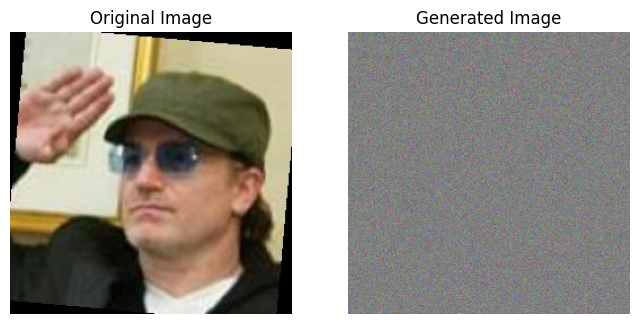

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x[0].permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(outputs[0].detach().cpu().numpy().transpose(1, 2, 0))
axes[1].set_title('Generated Image')
axes[1].axis('off')

plt.show()